## Independent Study: Exploring Feiyu's code
### March 2020

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from neurodiffeq import ode
from neurodiffeq import diff
from neurodiffeq.ode import solve_system
import torch.nn as nn
from neurodiffeq.networks import FCNN

In [2]:
ode.solve

<function neurodiffeq.ode.solve(ode, condition, t_min=None, t_max=None, net=None, train_generator=None, shuffle=True, valid_generator=None, optimizer=None, criterion=None, additional_loss_term=None, metrics=None, batch_size=16, max_epochs=1000, monitor=None, return_internal=False, return_best=False)>

The equation we wish to solve is the following:

$$\frac{d^2 x}{d t^2} + \omega^2x = 0$$

With initial conditions $x(0) = x_0$ and $\frac{d x}{d t}(0) = v_0$

The analytical solution is equal to:

$$x(t) = \frac{v_0}{\omega}\sin(\omega t) + x_0$$

In [4]:
# let's define the problem
x0 = 0.0
v0 = 1.0
omega = 2.0

In [10]:
oscillator = lambda x, t: diff(x, t, order=2) + (omega**2)*x
init_val_ho = ode.IVP(t_0=0.0, x_0=0.0, x_0_prime=1.0)
net_ho = FCNN(
    n_hidden_layers=2, n_hidden_units=32, actv=nn.Tanh
)
solution_ho, loss = ode.solve(ode=oscillator, condition=init_val_ho, net = net_ho,
                       max_epochs=6000,t_min=0.0, t_max=2*np.pi)

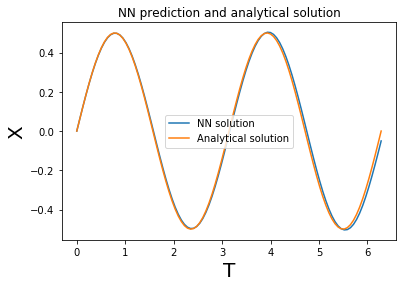

In [11]:
ts = np.linspace(0, 2*np.pi, 100)
x_net = solution_ho(ts, as_type='np')
x_ana = 1/omega*np.sin(omega*ts)
plt.figure()
plt.plot(ts, x_net, label = 'NN solution')
plt.plot(ts, x_ana, label = 'Analytical solution')
plt.title('NN prediction and analytical solution')
plt.xlabel('T', fontsize = 20)
plt.ylabel('X', fontsize = 20)
plt.legend()

No handles with labels found to put in legend.


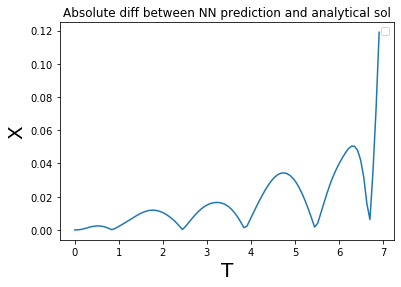

In [19]:
ts = np.linspace(0, 2.2*np.pi, 100)
x_net = solution_ho(ts, as_type='np')
x_ana = 1/omega*np.sin(omega*ts)
plt.figure()
plt.plot(ts, abs(x_net - x_ana))
plt.title('Absolute diff between NN prediction and analytical sol')
plt.xlabel('T', fontsize = 20)
plt.ylabel('X', fontsize = 20)
plt.legend()

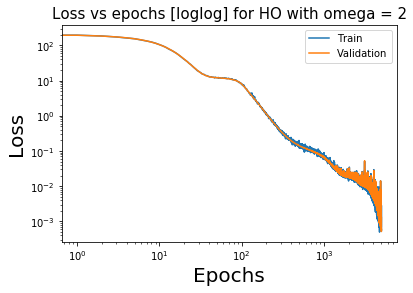

In [15]:
epochs = range(len(loss['train_loss']))
plt.figure()
plt.loglog(epochs, loss['train_loss'], label = 'Train')
plt.loglog(epochs, loss['valid_loss'], label = 'Validation')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.title('Loss vs epochs [loglog] for HO with omega = 2', fontsize = 15)
plt.legend()

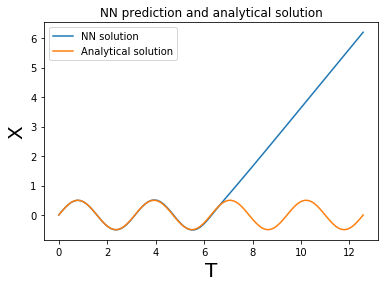

In [16]:
ts = np.linspace(0, 4*np.pi, 100)
x_net = solution_ho(ts, as_type='np')
x_ana = 1/omega*np.sin(omega*ts)
plt.figure()
plt.plot(ts, x_net, label = 'NN solution')
plt.plot(ts, x_ana, label = 'Analytical solution')
plt.title('NN prediction and analytical solution')
plt.xlabel('T', fontsize = 20)
plt.ylabel('X', fontsize = 20)
plt.legend()

## Let's try Chebyshev

In [34]:
# define problem
omega = 2
oscillator = lambda x, t: diff(x, t, order=2) + (omega**2)*x
init_val_ho = ode.IVP(t_0=0.0, x_0=0.0, x_0_prime=1.0)

# solve with default uniform
train_gen = ode.ExampleGenerator(size=100,  t_min=0.0, t_max=2*np.pi, method='uniform')
valid_gen = ode.ExampleGenerator(size=100, t_min=0.0, t_max=2*np.pi, method='equally-spaced')
solution_ho_uni, loss_uniform = ode.solve(
    ode=oscillator, condition=init_val_ho, t_min=0.0, t_max=2*np.pi,
    train_generator=train_gen, valid_generator=valid_gen, 
    max_epochs=3000
)

# solve with chebyshev
train_gen = ode.ExampleGenerator(size=100,  t_min=0.0, t_max=2*np.pi, method='chebyshev')
valid_gen = ode.ExampleGenerator(size=100, t_min=0.0, t_max=2*np.pi, method='equally-spaced')
solution_ho_cheby, loss_cheby = ode.solve(
    ode=oscillator, condition=init_val_ho, t_min=0.0, t_max=2*np.pi,
    train_generator=train_gen, valid_generator=valid_gen,
    max_epochs=3000
)

KeyboardInterrupt: 

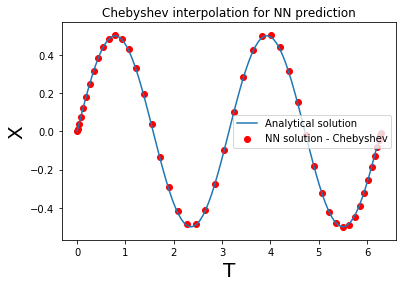

In [28]:
t_min = 0
t_max = 2*np.pi
ts = np.linspace(0, 2*np.pi, 100)
ts_cheby = []
for k in range(1, 50+1):
    ts_cheby.append((t_min+t_max)/2 + 1/2*(t_max-t_min)*np.cos((2*k-1)*np.pi/(2*50)))

x_net = solution_ho_cheby(ts_cheby, as_type='np')
x_ana = 1/omega*np.sin(omega*ts)
plt.figure()
plt.scatter(ts_cheby, x_net, label = 'NN solution - Chebyshev', c = 'red')
plt.plot(ts, x_ana, label = 'Analytical solution')
plt.title('Chebyshev interpolation for NN prediction')
plt.xlabel('T', fontsize = 20)
plt.ylabel('X', fontsize = 20)
plt.legend()

Text(0.5, 1.0, 'Loss vs epochs [loglog] for HO with omega = 2')

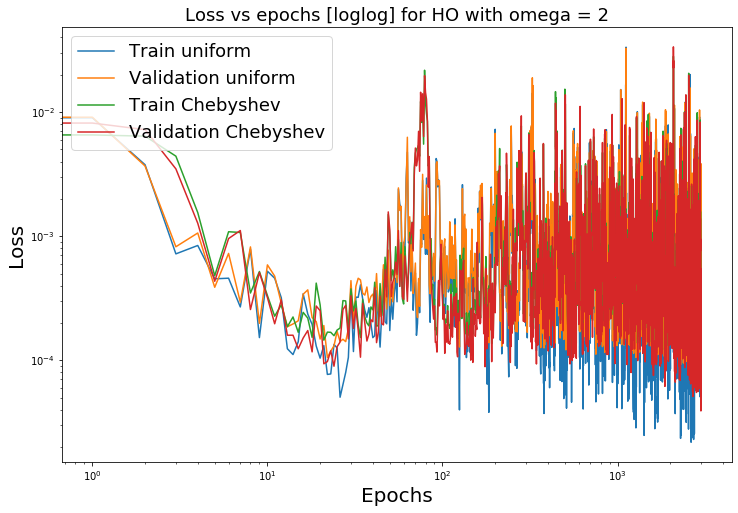

In [33]:
epochs = range(len(loss_cheby['train_loss']))
plt.figure(figsize = (12,8))
plt.loglog(epochs, loss_uniform['train_loss'], label = 'Train uniform')
plt.loglog(epochs, loss_uniform['valid_loss'], label = 'Validation uniform')
plt.loglog(epochs, loss_cheby['train_loss'], label = 'Train Chebyshev')
plt.loglog(epochs, loss_cheby['valid_loss'], label = 'Validation Chebyshev')
plt.legend(fontsize = 18)
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.title('Loss vs epochs [loglog] for HO with omega = 2', fontsize = 18)

Text(0.5, 1.0, 'Loss vs epochs [loglog] for HO with omega = 4')

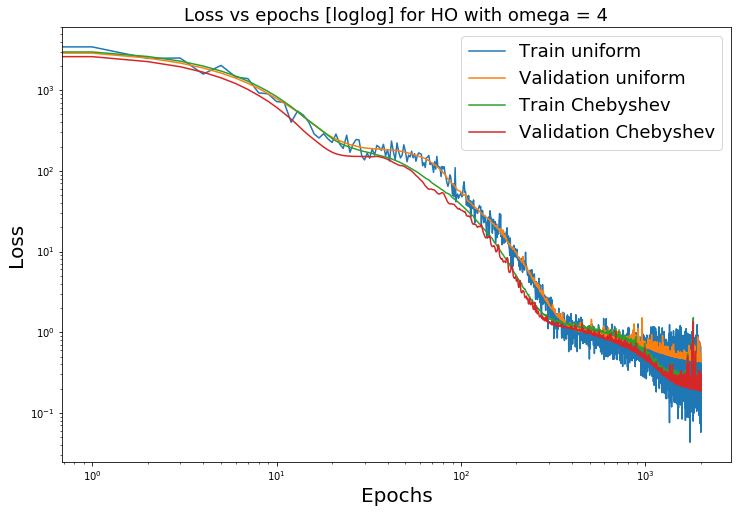

In [7]:
# define problem
omega = 4
oscillator = lambda x, t: diff(x, t, order=2) + (omega**2)*x
init_val_ho = ode.IVP(t_0=0.0, x_0=0.0, x_0_prime=1.0)

# solve with default uniform
train_gen = ode.ExampleGenerator(size=50,  t_min=0.0, t_max=2*np.pi, method='uniform')
valid_gen = ode.ExampleGenerator(size=100, t_min=0.0, t_max=2*np.pi, method='equally-spaced')
solution_ho, loss_uniform = ode.solve(
    ode=oscillator, condition=init_val_ho, t_min=0.0, t_max=2*np.pi,
    train_generator=train_gen, valid_generator=valid_gen,
    max_epochs=2000
)

# solve with chebyshev
train_gen = ode.ExampleGenerator(size=50,  t_min=0.0, t_max=2*np.pi, method='chebyshev')
valid_gen = ode.ExampleGenerator(size=100, t_min=0.0, t_max=2*np.pi, method='equally-spaced')
solution_ho, loss_cheby = ode.solve(
    ode=oscillator, condition=init_val_ho, t_min=0.0, t_max=2*np.pi,
    train_generator=train_gen, valid_generator=valid_gen,
    max_epochs=2000
)

epochs = range(len(loss_cheby['train_loss']))
plt.figure(figsize = (12,8))
plt.loglog(epochs, loss_uniform['train_loss'], label = 'Train uniform')
plt.loglog(epochs, loss_uniform['valid_loss'], label = 'Validation uniform')
plt.loglog(epochs, loss_cheby['train_loss'], label = 'Train Chebyshev')
plt.loglog(epochs, loss_cheby['valid_loss'], label = 'Validation Chebyshev')
plt.legend(fontsize = 18)
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.title('Loss vs epochs [loglog] for HO with omega = 4', fontsize = 18)

Text(0.5, 1.0, 'Loss vs epochs [loglog] for EXPONENTIAL')

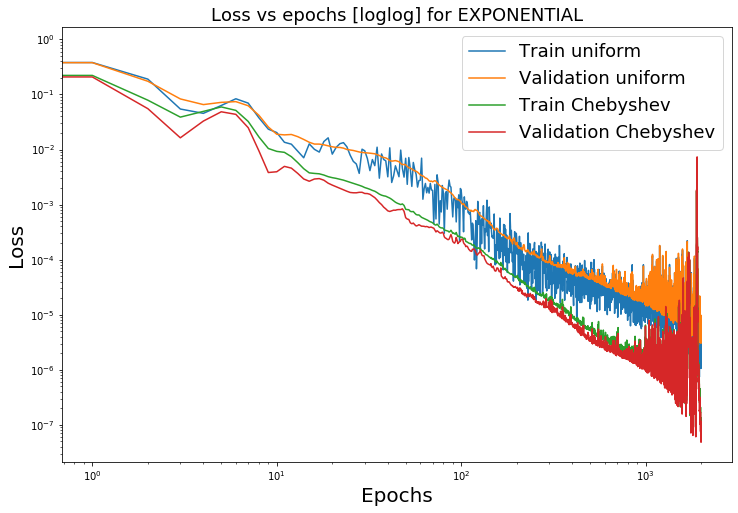

In [9]:
# define problem
exponential = lambda x, t: diff(x, t) + x
init_val_ho = ode.IVP(t_0=0.0, x_0=1)

# solve with default uniform
train_gen = ode.ExampleGenerator(size=50,  t_min=0.0, t_max=2*np.pi, method='uniform')
valid_gen = ode.ExampleGenerator(size=100, t_min=0.0, t_max=2*np.pi, method='equally-spaced')
solution_ho, loss_uniform = ode.solve(
    ode=exponential, condition=init_val_ho, t_min=0.0, t_max=2*np.pi,
    train_generator=train_gen, valid_generator=valid_gen,
    max_epochs=2000
)

# solve with chebyshev
train_gen = ode.ExampleGenerator(size=50,  t_min=0.0, t_max=2*np.pi, method='chebyshev')
valid_gen = ode.ExampleGenerator(size=100, t_min=0.0, t_max=2*np.pi, method='equally-spaced')
solution_ho, loss_cheby = ode.solve(
    ode=exponential, condition=init_val_ho, t_min=0.0, t_max=2*np.pi,
    train_generator=train_gen, valid_generator=valid_gen,
    max_epochs=2000
)

epochs = range(len(loss_cheby['train_loss']))
plt.figure(figsize = (12,8))
plt.loglog(epochs, loss_uniform['train_loss'], label = 'Train uniform')
plt.loglog(epochs, loss_uniform['valid_loss'], label = 'Validation uniform')
plt.loglog(epochs, loss_cheby['train_loss'], label = 'Train Chebyshev')
plt.loglog(epochs, loss_cheby['valid_loss'], label = 'Validation Chebyshev')
plt.legend(fontsize = 18)
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.title('Loss vs epochs [loglog] for EXPONENTIAL', fontsize = 18)

In [11]:
# let's plot inside and outside domain for both interpolation methods

# define problem
omega = 2
oscillator = lambda x, t: diff(x, t, order=2) + (omega**2)*x
init_val_ho = ode.IVP(t_0=0.0, x_0=0.0, x_0_prime=1.0)

# solve with default uniform
train_gen = ode.ExampleGenerator(size=50,  t_min=0.0, t_max=2*np.pi, method='uniform')
valid_gen = ode.ExampleGenerator(size=100, t_min=0.0, t_max=2*np.pi, method='equally-spaced')
solution_ho_uni, _ = ode.solve(
    ode=oscillator, condition=init_val_ho, t_min=0.0, t_max=2*np.pi,
    train_generator=train_gen, valid_generator=valid_gen,
    max_epochs=3000
)

# solve with chebyshev
train_gen = ode.ExampleGenerator(size=50,  t_min=0.0, t_max=2*np.pi, method='chebyshev')
valid_gen = ode.ExampleGenerator(size=100, t_min=0.0, t_max=2*np.pi, method='equally-spaced')
solution_ho_cheby, _ = ode.solve(
    ode=oscillator, condition=init_val_ho, t_min=0.0, t_max=2*np.pi,
    train_generator=train_gen, valid_generator=valid_gen,
    max_epochs=3000
)

Text(0.5, 1.0, 'NN predictions for HO inside and outside training domain')

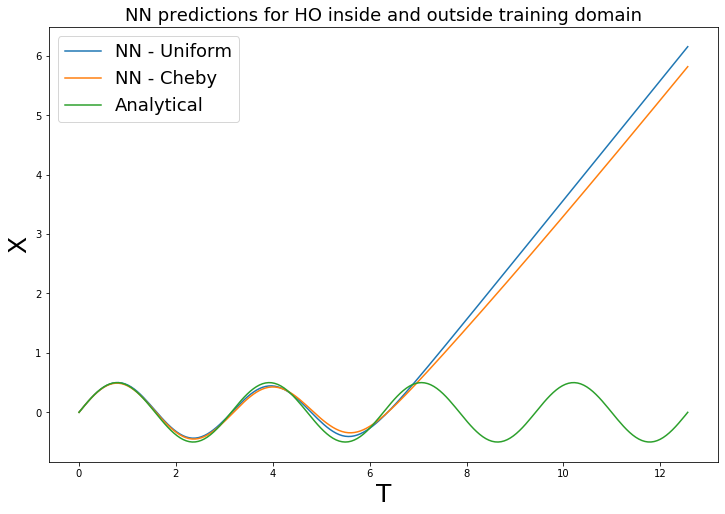

In [13]:
ts = np.linspace(0, 4*np.pi, 200)
pred_uni = solution_ho_uni(ts, as_type='np')
pred_cheby = solution_ho_cheby(ts, as_type='np')
analyt = 1/omega*np.sin(omega*ts)

plt.figure(figsize = (12,8))
plt.plot(ts, pred_uni, label = 'NN - Uniform')
plt.plot(ts, pred_cheby, label = 'NN - Cheby')
plt.plot(ts, analyt, label = 'Analytical')
plt.legend(fontsize = 18)
plt.xlabel('T', fontsize = 25)
plt.ylabel('X', fontsize = 25)
plt.title('NN predictions for HO inside and outside training domain', fontsize = 18)

## Let's experiment with Pavlos' masternode

In [5]:
from neurodiffeq import ode_masternode

In [6]:
class SineFunction(nn.Module):
    
    def forward(self, x):
        return torch.sin(x)
    
class FCNN_masternode(nn.Module):
    """A fully connected neural network.
    :param n_input_units: number of units in the input layer, defaults to 1.
    :type n_input_units: int
    :param n_input_units: number of units in the output layer, defaults to 1.
    :type n_input_units: int
    :param n_hidden_units: number of hidden units in each hidden layer, defaults to 32.
    :type n_hidden_units: int
    :param n_hidden_layers: number of hidden layers, defaults to 1.
    :type n_hidden_layers: int
    :param actv: the activation layer used in each hidden layer, defaults to `torch.nn.Tanh`.
    :type actv: `torch.nn.Module`
    """
    def __init__(self, n_input_units=1, n_output_units=1, n_hidden_units=32, n_hidden_layers=1,
                 actv=nn.Tanh):
        r"""Initializer method.
        """
        super(FCNN_masternode, self).__init__()

        layers = []
        # add masternode
        layers.append(nn.Linear(n_input_units, n_input_units))
        layers.append(SineFunction())
        layers.append(nn.Linear(n_input_units, n_hidden_units))
        layers.append(actv())
        for i in range(n_hidden_layers):
            layers.append(nn.Linear(n_hidden_units, n_hidden_units))
            layers.append(actv())
        layers.append(nn.Linear(n_hidden_units, n_output_units))
        self.NN = torch.nn.Sequential(*layers)

    def forward(self, t):
        x = self.NN(t)
        return x

In [7]:
net_ho = FCNN_masternode(n_hidden_layers=2, n_hidden_units=32, actv=nn.Tanh)

# define problem
omega = 2
oscillator = lambda x, t: diff(x, t, order=2) + (omega**2)*x
init_val_ho = ode.IVP(t_0=0.0, x_0=0.0, x_0_prime=1.0)

# define domain and solution
ts = np.linspace(0, 4*np.pi, 200)
analyt = 1/omega*np.sin(omega*ts)

# solve the ODE
solution_ho, _ = ode.solve(
    ode=oscillator, condition=init_val_ho,  t_min=0.0, t_max=2*np.pi,
    net=net_ho,max_epochs=5000,
)

pred_wo_per_enforce = solution_ho(ts, as_type = 'np')

KeyboardInterrupt: 

In [8]:
net_ho = FCNN_masternode(n_hidden_layers=2, n_hidden_units=32, actv=nn.Tanh)

# define problem
omega = 2
oscillator = lambda x, t: diff(x, t, order=2) + (omega**2)*x
init_val_ho = ode.IVP(t_0=0.0, x_0=0.0, x_0_prime=1.0)

# solve the ODE
solution_ho, _ = ode_masternode.solve(
    ode=oscillator, condition=init_val_ho,  t_min=0.0, t_max=2*np.pi,
    net=net_ho,max_epochs=5000,
)

pred_per_enforce = solution_ho(ts, as_type = 'np')

Text(0.5, 1.0, 'NN predictions for HO inside and outside training domain')

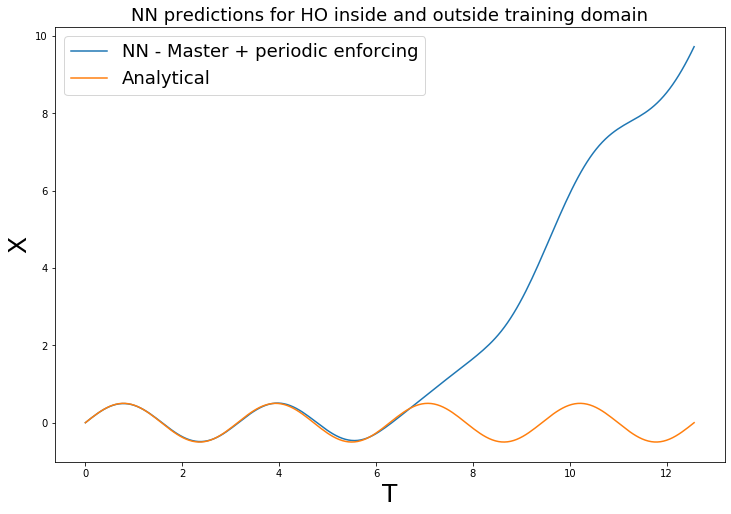

In [9]:
plt.figure(figsize = (12,8))
#plt.plot(ts, pred_wo_per_enforce, label = 'NN - Master + NO periodic enforcing')
plt.plot(ts, pred_per_enforce, label = 'NN - Master + periodic enforcing')
plt.plot(ts, analyt, label = 'Analytical')
plt.legend(fontsize = 18)
plt.xlabel('T', fontsize = 25)
plt.ylabel('X', fontsize = 25)
plt.title('NN predictions for HO inside and outside training domain', fontsize = 18)